In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
data = pd.read_csv('mergedClean.csv')

In [ ]:
# Convert the 'Auto Renew' column to binary values
data['Auto Renew'] = data['Auto Renew'].apply(lambda x: 1 if x == 'Yes' else 0)

# Aggregate the data by 'ID'
aggregated_data = data.groupby('ID').agg({
    'App Activity Type': lambda x: x[x != ''].count(),
    'Subscription Expiration': 'first',
    'Auto Renew': 'first',
    # Add the rest of the columns from the original dataset
    'Language': 'first',
    'Subscription Type': 'first',
    'Subscription Event Type': 'first',
    'Purchase Store': 'first',
    'Purchase Amount': 'first',
    'Currency': 'first',
    'Subscription Start Date': 'first',
    'Demo User': 'first',
    'Free Trial User': 'first',
    'Free Trial Start Date': 'first',
    'Free Trial Expiration': 'first',
    'Country': 'first',
    'User Type': 'first',
    'Lead Platform': 'first',
    'Email Subscriber': 'first',
    'Push Notifications': 'first',
    'Send Count': 'first',
    'Open Count': 'first',
    'Click Count': 'first',
    'Unique Open Count': 'first',
    'Unique Click Count': 'first',
    'App Session Platform': 'first',
    'App Session Date': 'first'
}).reset_index()

# Define a churn function
def determine_churn(row):
    # Churn criteria: Subscription expiration date is before March 31st, 2020, or
    # (auto-renew is off and the count of non-empty App Activity Types is less than a threshold, e.g., 5)
    threshold = 5
    churned = (pd.to_datetime(row['Subscription Expiration']) < pd.Timestamp('2020-03-31') or
               (row['Auto Renew'] == 0 and row['App Activity Type'] < threshold))
    return int(churned)

# Apply the churn function to the aggregated data
aggregated_data['Churn'] = aggregated_data.apply(determine_churn, axis=1)

# Save the aggregated data with the churn column
aggregated_data.to_csv("Churn1.csv", index=False)

# Count the number of '1's in the 'Churn' column
num_churned = aggregated_data['Churn'].sum()

print(f"The number of churned customers is: {num_churned}")


The number of churned customers is: 27634


In [ ]:
data = pd.read_csv("Churn1.csv")
# Drop 'Free Trial Start Date' and 'Free Trial Expiration Date' columns
data = data.drop(columns=['Free Trial Start Date', 'Free Trial Expiration'])

# Drop rows with missing values in the remaining columns
data = data.dropna()
missing_values = data.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])
data.to_csv("Churn2.csv", index=False)

Columns with missing values:
Series([], dtype: int64)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

data = pd.read_csv("Churn2.csv")

# Convert the categorical variables into dummy variables
dummy_columns = ['Subscription Type', 'Purchase Store', 'Demo User','Free Trial User', 'Email Subscriber', 'Push Notifications', 'App Session Platform']
data = pd.get_dummies(data, columns=dummy_columns, drop_first=True)

# Replace spaces with underscores in column names
data.columns = data.columns.str.replace(' ', '_')

# Specify the dependent and independent variables
dependent_var = 'Churn'
independent_vars = [col for col in data.columns if col not in ['ID', 'App_Activity_Type', 'Country', 'Language', 'Subscription_Expiration', 'Auto_Renew', 'Churn', 'Subscription_Event_Type', 'Currency', 'Subscription_Start_Date', 'User_Type', 'Lead_Platform', 'App_Session_Date']]

# Create a DataFrame containing only independent variables
X = data[independent_vars].copy()
y = data[dependent_var]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the logistic regression model on the training data
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = lr_model.predict(X_train)
y_train_pred_proba = lr_model.predict_proba(X_train)[:, 1]

# Make predictions on the testing set
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics for the training set
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)  # Sensitivity
f1_train = f1_score(y_train, y_train_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)

# Calculate metrics for the testing set
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)  # Sensitivity
f1_test = f1_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_pred_proba)

print("\nTrain Metrics:")
print(f"Accuracy: {accuracy_train:.3f}")
print(f"Precision: {precision_train:.3f}")
print(f"Sensitivity (Recall): {recall_train:.3f}")
print(f"F1 Score: {f1_train:.3f}")
print(f"ROC AUC Score: {roc_auc_train:.3f}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_test:.3f}")
print(f"Precision: {precision_test:.3f}")
print(f"Sensitivity (Recall): {recall_test:.3f}")
print(f"F1 Score: {f1_test:.3f}")
print(f"ROC AUC Score: {roc_auc_test:.3f}")

# Print the coefficients of the independent variables
print("\nCoefficients:")
for var, coef in zip(independent_vars, lr_model.coef_[0]):
    print(f"{var}: {coef:.3f}")


Train Metrics:
Accuracy: 0.795
Precision: 0.783
Sensitivity (Recall): 0.666
F1 Score: 0.720
ROC AUC Score: 0.836

Test Metrics:
Accuracy: 0.784
Precision: 0.773
Sensitivity (Recall): 0.674
F1 Score: 0.720
ROC AUC Score: 0.837

Coefficients:
Purchase_Amount: -0.013
Send_Count: 0.018
Open_Count: -0.035
Click_Count: 0.015
Unique_Open_Count: 0.037
Unique_Click_Count: -0.193
Subscription_Type_Limited: 0.819
Purchase_Store_Web: 1.242
Demo_User_Yes: -0.564
Free_Trial_User_Yes: -0.745
Email_Subscriber_Yes: 0.014
App_Session_Platform_ios: -0.102
App_Session_Platform_web: -0.234


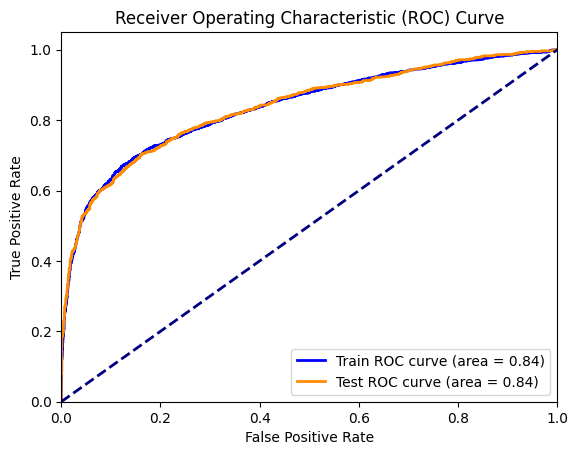

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR) and true positive rate (TPR) for all thresholds of the classification
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the Curve (AUC) for the ROC curve
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot the ROC curve for both the training and testing sets
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Calculate the false positive rate (FPR) and true positive rate (TPR) for all thresholds of the classification
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba)

# Create a DataFrame containing FPR, TPR, and thresholds for both the training and testing sets
roc_data_train = pd.DataFrame({'FPR_Train': fpr_train, 'TPR_Train': tpr_train, 'Thresholds_Train': thresholds_train})
roc_data_test = pd.DataFrame({'FPR_Test': fpr_test, 'TPR_Test': tpr_test, 'Thresholds_Test': thresholds_test})

# Combine the training and testing DataFrames
roc_data = pd.concat([roc_data_train, roc_data_test], axis=1)

# Save the DataFrame to a CSV file
roc_data.to_csv('roc_data.csv', index=False)

roc_data

,FPR_Train,TPR_Train,Thresholds_Train,FPR_Test,TPR_Test,Thresholds_Test
0,0.000000,0.000000,1.986855,0.0,0.000000,1.987482
1,0.000000,0.000353,0.986855,0.0,0.000789,0.987482
2,0.000000,0.041343,0.972908,0.0,0.050473,0.970679
3,0.000000,0.042049,0.972857,0.0,0.052839,0.970565
4,0.000000,0.043463,0.972312,0.0,0.082808,0.958070
...,...,...,...,...,...,...
2351,0.998150,0.999293,0.002705,NaN,NaN,NaN
2352,0.998613,0.999293,0.002683,NaN,NaN,NaN
2353,0.999769,0.999293,0.001252,NaN,NaN,NaN
2354,0.999769,1.000000,0.000246,NaN,NaN,NaN
